In [73]:
pip install pyro-ppl

# Linear regression

A linear model on the regression will provide as a basic estimation as to the performance of the data. The fast approximation will be a rough model and lack computational complexity.

In [74]:
import os
from functools import partial
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import pyro
import pyro.distributions as dist

# for CI testing
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.9.0')
pyro.set_rng_seed(1)

%matplotlib inline
plt.style.use('default')

In [75]:
from torch import nn
from pyro.nn import PyroModule

assert issubclass(PyroModule[nn.Linear], nn.Linear)
assert issubclass(PyroModule[nn.Linear], PyroModule)

In [49]:
train = pd.read_csv("/content/sample_data/california_housing_train.csv")
test = pd.read_csv("/content/sample_data/california_housing_test.csv")

df = pd.concat([train, test])

df['position'] = np.sqrt((df['longitude'] + df['latitude'])*(df['longitude'] + df['latitude']))
df['value'] = np.log(df['median_house_value'])

In [67]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,position,value
0,-114.31,34.19,15.0,5612.0,1283.0,1015.0,472.0,1.4936,66900.0,80.12,11.110954
1,-114.47,34.40,19.0,7650.0,1901.0,1129.0,463.0,1.8200,80100.0,80.07,11.291031
2,-114.56,33.69,17.0,720.0,174.0,333.0,117.0,1.6509,85700.0,80.87,11.358608
3,-114.57,33.64,14.0,1501.0,337.0,515.0,226.0,3.1917,73400.0,80.93,11.203679
4,-114.57,33.57,20.0,1454.0,326.0,624.0,262.0,1.9250,65500.0,81.00,11.089805


In [50]:
data = torch.tensor(df[["position",
                        "median_income",
                        "total_rooms",
                        "housing_median_age",
                        "value"]].values,dtype=torch.float)

In [51]:
data2 = torch.tensor(df[["position",
                        "median_income",
                        "housing_median_age",
                        "value"]].values,dtype=torch.float)

In [52]:
x_data = data2[:,:-1]
x_data

tensor([[80.1200,  1.4936, 15.0000],
        [80.0700,  1.8200, 19.0000],
        [80.8700,  1.6509, 17.0000],
        ...,
        [83.4000,  2.2895, 10.0000],
        [83.0200,  3.2708, 40.0000],
        [85.2100,  8.5608, 42.0000]])

In [53]:
y_data = data2[:,-1]
y_data

tensor([11.1110, 11.2910, 11.3586,  ..., 11.0349, 11.9984, 13.1224])

In [12]:
linear_reg_model = PyroModule[nn.Linear](3, 1)

In [13]:
loss_fn = torch.nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(linear_reg_model.parameters(), lr=0.05)
num_iterations = 1500 if not smoke_test else 2

In [14]:
pyro.clear_param_store()

def train():
    # run the model forward on the data
    y_pred = linear_reg_model(x_data).squeeze(-1)
    # calculate the mse loss
    loss = loss_fn(y_pred, y_data)
    # initialize gradients to zero
    optim.zero_grad()
    # backpropagate
    loss.backward()
    # take a gradient step
    optim.step()
    return loss

for j in range(num_iterations):
    loss = train()
    if (j + 1) % 50 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss.item()))


# Inspect learned parameters
print("Learned parameters:")
for name, param in linear_reg_model.named_parameters():
    print(name, param.data.numpy())

[iteration 0050] loss: 15090.0576
[iteration 0100] loss: 3216.5471
[iteration 0150] loss: 2832.6526
[iteration 0200] loss: 2830.2756
[iteration 0250] loss: 2830.1606
[iteration 0300] loss: 2830.0364
[iteration 0350] loss: 2829.8997
[iteration 0400] loss: 2829.7500
[iteration 0450] loss: 2829.5898
[iteration 0500] loss: 2829.4170
[iteration 0550] loss: 2829.2339
[iteration 0600] loss: 2829.0393
[iteration 0650] loss: 2828.8337
[iteration 0700] loss: 2828.6177
[iteration 0750] loss: 2828.3914
[iteration 0800] loss: 2828.1528
[iteration 0850] loss: 2827.9041
[iteration 0900] loss: 2827.6443
[iteration 0950] loss: 2827.3740
[iteration 1000] loss: 2827.0925
[iteration 1050] loss: 2826.7998
[iteration 1100] loss: 2826.4958
[iteration 1150] loss: 2826.1809
[iteration 1200] loss: 2825.8545
[iteration 1250] loss: 2825.5166
[iteration 1300] loss: 2825.1670
[iteration 1350] loss: 2824.8062
[iteration 1400] loss: 2824.4324
[iteration 1450] loss: 2824.0474
[iteration 1500] loss: 2823.6504
Learned p

# Bayesian Regression with stochastic variational inference

In [76]:
from pyro.nn import PyroSample


class BayesianRegression(PyroModule):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = PyroModule[nn.Linear](in_features, out_features)
        self.linear.weight = PyroSample(dist.Normal(0., 1.).expand([out_features, in_features]).to_event(2))
        self.linear.bias = PyroSample(dist.Normal(0., 10.).expand([out_features]).to_event(1))

    def forward(self, x, y=None):
        sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
        mean = self.linear(x).squeeze(-1)
        with pyro.plate("data", x.shape[0]):
            obs = pyro.sample("obs", dist.Normal(mean, sigma), obs=y)
        return mean

In [77]:
from pyro.infer.autoguide import AutoDiagonalNormal

model = BayesianRegression(3, 1)
guide = AutoDiagonalNormal(model)

In [78]:
from pyro.infer import SVI, Trace_ELBO

adam = pyro.optim.Adam({"lr": 0.03})
svi = SVI(model, guide, adam, loss=Trace_ELBO())

In [57]:
pyro.clear_param_store()
for j in range(num_iterations):
    # calculate the loss and take a gradient step
    loss = svi.step(x_data, y_data)
    if j % 100 == 0:
        print("[iteration %04d] loss: %.4f" % (j + 1, loss / len(data2)))

[iteration 0001] loss: 9.9807
[iteration 0101] loss: 2.7738
[iteration 0201] loss: 2.9700
[iteration 0301] loss: 2.2702
[iteration 0401] loss: 2.0380
[iteration 0501] loss: 2.5638
[iteration 0601] loss: 1.4441
[iteration 0701] loss: 1.2555
[iteration 0801] loss: 1.0579
[iteration 0901] loss: 0.6436
[iteration 1001] loss: 1.2386
[iteration 1101] loss: 1.5029
[iteration 1201] loss: 0.9902
[iteration 1301] loss: 0.8761
[iteration 1401] loss: 0.5376


In [58]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

AutoDiagonalNormal.loc Parameter containing:
tensor([-3.1078,  0.1383,  0.1864,  0.0054, -0.3472])
AutoDiagonalNormal.scale tensor([0.0306, 0.0007, 0.0028, 0.0012, 0.0086])


In [59]:
from pyro.infer import Predictive


def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats


predictive = Predictive(model, guide=guide, num_samples=800,
                        return_sites=("linear.weight", "obs", "_RETURN"))
samples = predictive(x_data)
pred_summary = summary(samples)

In [60]:
mu = pred_summary["_RETURN"]
y = pred_summary["obs"]
predictions = pd.DataFrame({
    "position": x_data[:, 0],
    "median_income": x_data[:, 1],
    "housing_median_age": x_data[:, 2],
    "mu_mean": mu["mean"],
    "mu_perc_5": mu["5%"],
    "mu_perc_95": mu["95%"],
    "y_mean": y["mean"],
    "y_perc_5": y["5%"],
    "y_perc_95": y["95%"],
    "true_val": y_data,
})

[Text(0.5, 0, 'Position'),
 Text(0, 0.5, 'Value'),
 Text(0.5, 1.0, 'Higher Median Income')]

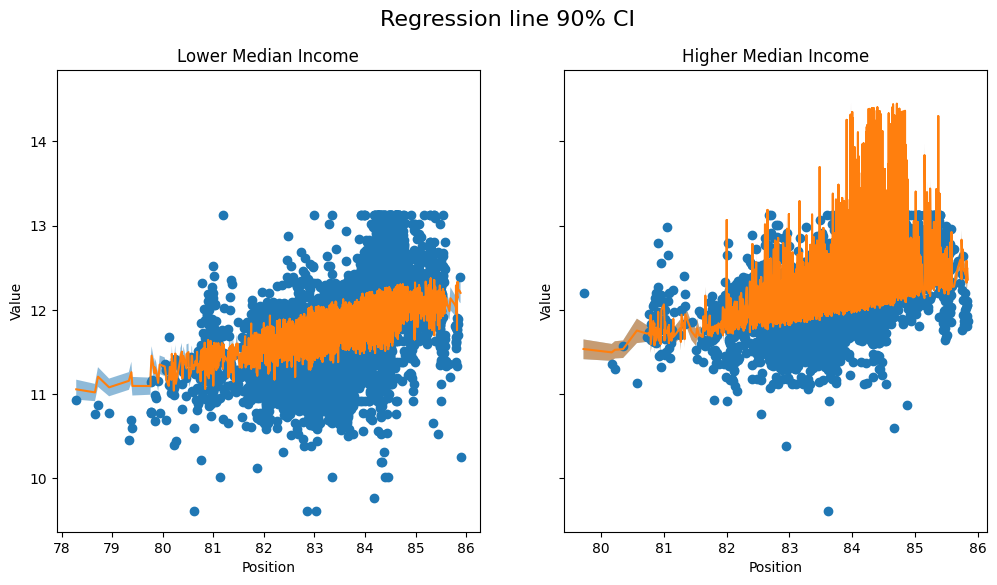

In [64]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
rich = predictions[predictions["median_income"] >= 3.5]
poor = predictions[predictions["median_income"] < 3.5]
rich = rich.sort_values(by=["position"])
poor = poor.sort_values(by=["position"])

fig.suptitle("Regression line 90% CI", fontsize=16)


ax[0].plot(poor["position"],
           poor["true_val"],
           "o")
ax[0].plot(poor["position"],
           poor["mu_mean"])
ax[0].fill_between(poor["position"],
                   poor["mu_perc_5"],
                   poor["mu_perc_95"],
                   alpha=0.5)
ax[0].set(xlabel="Position",
          ylabel="Value",
          title="Lower Median Income")

idx = np.argsort(rich["position"])

ax[1].fill_between(rich["position"],
                   rich["mu_perc_5"],
                   rich["mu_perc_95"],
                   alpha=0.5)
ax[1].plot(rich["position"],
           rich["true_val"],
           "o")
ax[1].plot(rich["position"],
           rich["mu_mean"])
ax[1].fill_between(rich["position"],
                   rich["mu_perc_5"],
                   rich["mu_perc_95"],
                   alpha=0.5)
ax[1].set(xlabel="Position",
          ylabel="Value",
          title="Higher Median Income")

The above figure shows the uncertainty in our estimate of the regression line, and the 90% CI around the mean. We can also see that most of the data points actually lie outside the 90% CI, and this is expected because we have not plotted the outcome variable which will be affected by sigma! Let us do so next.

[Text(0.5, 0, 'Position'),
 Text(0, 0.5, 'Value'),
 Text(0.5, 1.0, 'Higher Median Income')]

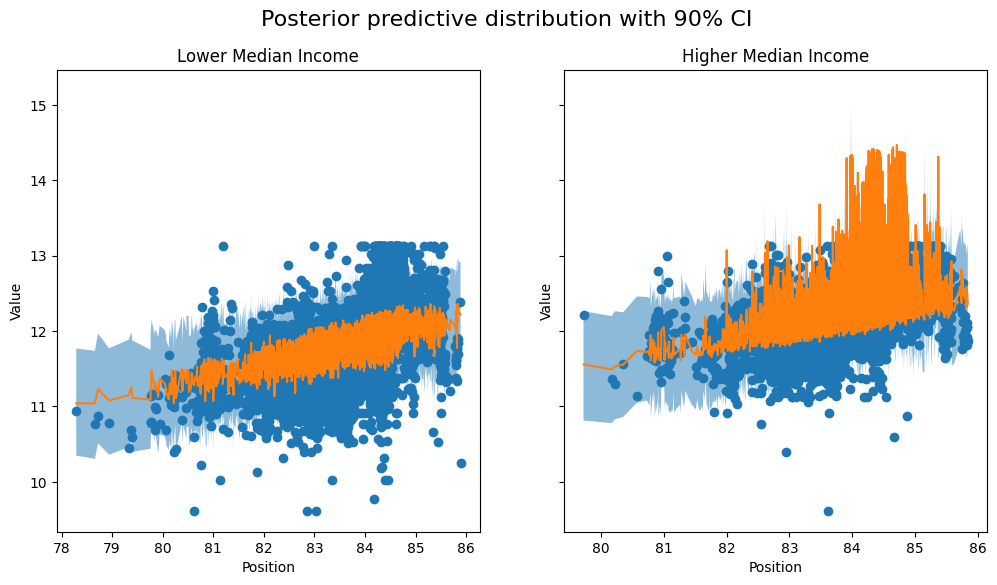

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6), sharey=True)
fig.suptitle("Posterior predictive distribution with 90% CI", fontsize=16)
ax[0].plot(poor["position"],
           poor["true_val"],
           "o")
ax[0].plot(poor["position"],
           poor["y_mean"])
ax[0].fill_between(poor["position"],
                   poor["y_perc_5"],
                   poor["y_perc_95"],
                   alpha=0.5)
ax[0].set(xlabel="Position",
          ylabel="Value",
          title="Lower Median Income")
idx = np.argsort(rich["position"])

ax[1].plot(rich["position"],
           rich["true_val"],
           "o")
ax[1].plot(rich["position"],
           rich["y_mean"])
ax[1].fill_between(rich["position"],
                   rich["y_perc_5"],
                   rich["y_perc_95"],
                   alpha=0.5)
ax[1].set(xlabel="Position",
          ylabel="Value",
          title="Higher Median Income")

We observe that the outcome from our model and the 90% CI accounts for the majority of the data points that we observe in practice. It is usually a good idea to do such posterior predictive checks to see if our model gives valid predictions.

# Bayesian Regression - Inference

In [85]:
import logging
import os

import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
import pyro.optim as optim

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('1.9.0')

In [86]:
%matplotlib inline
plt.style.use('default')

logging.basicConfig(format='%(message)s', level=logging.INFO)
smoke_test = ('CI' in os.environ)
pyro.set_rng_seed(1)
DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
rugged_data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")

In [87]:
train = pd.read_csv("/content/sample_data/california_housing_train.csv")
test = pd.read_csv("/content/sample_data/california_housing_test.csv")

df = pd.concat([train, test])

df['position'] = np.sqrt((df['longitude'] + df['latitude'])*(df['longitude'] + df['latitude']))
df['value'] = np.log(df['median_house_value'])

In [88]:
def model(position, income, value):
    a = pyro.sample("a", dist.Normal(0., 10.))
    b_a = pyro.sample("bA", dist.Normal(0., 1.))
    b_r = pyro.sample("bR", dist.Normal(0., 1.))
    b_ar = pyro.sample("bAR", dist.Normal(0., 1.))
    sigma = pyro.sample("sigma", dist.Uniform(0., 10.))
    mean = a + b_a * position + b_r * income + b_ar * position * income
    with pyro.plate("data", len(income)):
        pyro.sample("obs", dist.Normal(mean, sigma), obs=value)

def guide(position, income, value):
    a_loc = pyro.param('a_loc', torch.tensor(0.))
    a_scale = pyro.param('a_scale', torch.tensor(1.),
                         constraint=constraints.positive)
    sigma_loc = pyro.param('sigma_loc', torch.tensor(1.),
                             constraint=constraints.positive)
    weights_loc = pyro.param('weights_loc', torch.randn(3))
    weights_scale = pyro.param('weights_scale', torch.ones(3),
                               constraint=constraints.positive)
    a = pyro.sample("a", dist.Normal(a_loc, a_scale))
    b_a = pyro.sample("bA", dist.Normal(weights_loc[0], weights_scale[0]))
    b_r = pyro.sample("bR", dist.Normal(weights_loc[1], weights_scale[1]))
    b_ar = pyro.sample("bAR", dist.Normal(weights_loc[2], weights_scale[2]))
    sigma = pyro.sample("sigma", dist.Normal(sigma_loc, torch.tensor(0.05)))
    mean = a + b_a * position + b_r * income + b_ar * position * income


In [89]:
# Utility function to print latent sites' quantile information.
def summary(samples):
    site_stats = {}
    for site_name, values in samples.items():
        marginal_site = pd.DataFrame(values)
        describe = marginal_site.describe(percentiles=[.05, 0.25, 0.5, 0.75, 0.95]).transpose()
        site_stats[site_name] = describe[["mean", "std", "5%", "25%", "50%", "75%", "95%"]]
    return site_stats

# Prepare training data
df = df[["position", "median_income", "value"]]
df = df[np.isfinite(df.value)]
train = torch.tensor(df.values, dtype=torch.float)

In [93]:
df.describe()

,position,median_income,value
count,20000.000000,20000.000000,20000.000000
mean,83.939422,3.872132,12.085823
std,0.811209,1.900356,0.569471
min,78.290000,0.499900,9.615739
25%,83.550000,2.562500,11.693579
50%,84.180000,3.536000,12.099600
75%,84.420000,4.745325,12.487485
max,85.890000,15.000100,13.122365


In [94]:
from pyro.infer import SVI, Trace_ELBO


svi = SVI(model,
          guide,
          optim.Adam({"lr": .05}),
          loss=Trace_ELBO())

position, income, value = train[:, 0], train[:, 1], train[:, 2]
pyro.clear_param_store()
num_iters = 500 if not smoke_test else 2
for i in range(num_iters):
    elbo = svi.step(position, income, value)
    if i % 500 == 0:
        logging.info("Elbo loss: {}".format(elbo))



In [96]:
from pyro.infer import Predictive


num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(value, position, income).items()
               if k != "obs"}



Let us observe the posterior distribution over the different latent variables in the model.

In [97]:
for site, values in summary(svi_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean       std        5%       25%       50%       75%       95%
0  0.785975  1.357076 -1.492948 -0.040502  0.820043  1.695153  2.922685 

Site: bA
       mean       std        5%       25%       50%       75%       95%
0  1.126053  0.393487  0.492485  0.840613  1.132067  1.403764  1.757706 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0  2.117982  1.118139  0.284571  1.374572  2.116101  2.825511  3.995557 

Site: bAR
       mean       std       5%       25%       50%       75%       95%
0 -0.257405  0.168038 -0.53155 -0.369579 -0.256328 -0.145778  0.016638 

Site: sigma
      mean       std        5%       25%       50%       75%       95%
0  4.73857  0.047953  4.659637  4.705932  4.737878  4.771544  4.816655 



# MCMC

In contrast to using variational inference which gives us an approximate posterior over our latent variables, we can also do exact inference using Markov Chain Monte Carlo (MCMC), a class of algorithms that in the limit, allow us to draw unbiased samples from the true posterior. The algorithm that we will be using is called the No-U Turn Sampler (NUTS), which provides an efficient and automated way of running Hamiltonian Monte Carlo. It is slightly slower than variational inference, but provides an exact estimate.

In [105]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=100, warmup_steps=20)
mcmc.run(position, income, value)


hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}



Sample: 100%|██████████| 120/120 [00:23,  5.12it/s, step size=9.20e-04, acc. prob=0.692]


In [106]:
for site, values in summary(hmc_samples).items():
    print("Site: {}".format(site))
    print(values, "\n")

Site: a
       mean     std       5%       25%       50%       75%       95%
0  0.838894  0.0022  0.83581  0.837071  0.838392  0.841155  0.842229 

Site: bA
     mean       std        5%       25%       50%       75%      95%
0  0.1159  0.036899 -0.011939  0.124948  0.125132  0.125423  0.12585 

Site: bAR
       mean       std        5%       25%       50%       75%       95%
0 -0.010421  0.007669 -0.012476 -0.012409 -0.012345 -0.012276  0.016117 

Site: bR
       mean       std        5%       25%       50%       75%       95%
0  1.228843  0.001423  1.226921  1.227713  1.228544  1.229716  1.231126 

Site: sigma
       mean       std       5%       25%       50%       75%       95%
0  1.520987  0.093969  1.40542  1.442407  1.512207  1.591153  1.669899 



Let us compare the posterior distribution of the latent variables that we obtained from variational inference with those from Hamiltonian Monte Carlo. As can be seen below, for Variational Inference, the marginal distribution of the different regression coefficients is under-dispersed w.r.t. the true posterior (from HMC). This is an artifact of the KL(q||p) loss (the KL divergence of the true posterior from the approximate posterior) that is minimized by Variational Inference.

This can be better seen when we plot different cross sections from the joint posterior distribution overlaid with the approximate posterior from variational inference. Note that since our variational family has diagonal covariance, we cannot model any correlation between the latents and the resulting approximation is overconfident (under-dispersed)

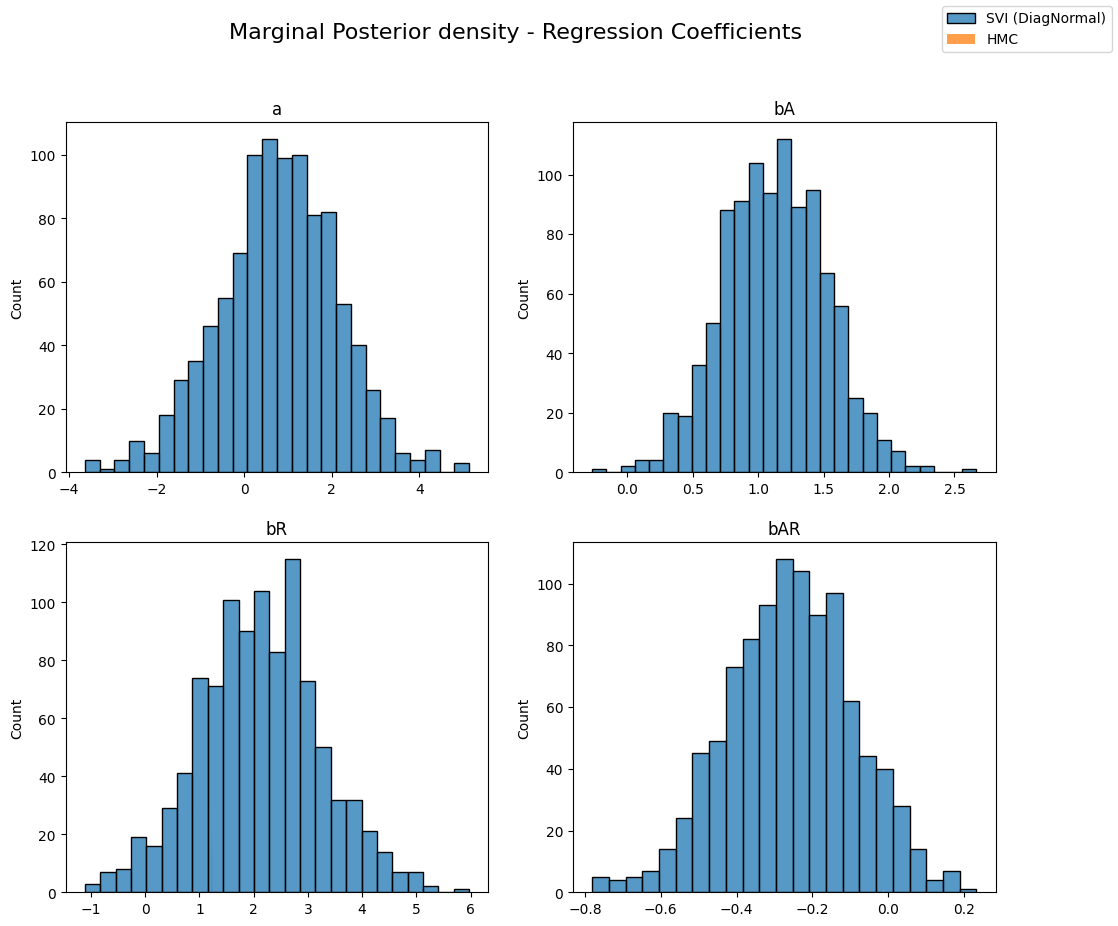

In [112]:
sites = ["a", "bA", "bR", "bAR", "sigma"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
fig.suptitle("Marginal Posterior density - Regression Coefficients", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    site = sites[i]
    sns.histplot(svi_samples[site], ax=ax, label="SVI (DiagNormal)")
    sns.histplot(hmc_samples[site], ax=ax, label="HMC")
    ax.set_title(site)
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');